In [1]:
# from cityscapesscripts.download import downloader
import torch
from PIL import Image
import json
import glob
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import stats

from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models.segmentation as segmentation


from utility import CityscapeSegTemp, get_min_max, train, evaluate, plot_samples, plot_predictions, plot_metrics

from utility import cityscapes_cmap, plot_class_colors


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)  
elif torch.backends.mps.is_available():  # Check for M1 GPU availability
    device = torch.device("mps")  # M1 GPU
    gpu_name = "Apple M1"
else:
    device = torch.device("cpu")
    gpu_name = "CPU"

print(f"Using device: {device}, GPU: {gpu_name}")

Using device: cuda, GPU: NVIDIA GeForce RTX 4090


In [3]:
temp_min, temp_max = get_min_max('./data')

print(temp_min, temp_max)

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

13.5 44.5


In [4]:
aug = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CityscapeSegTemp(root_dir ='./data', split = 'train', 
                                 device = device, 
                                 transform = aug, 
                                 temp_scale=(temp_min, temp_max)
                                 )



val_dataset =   CityscapeSegTemp(root_dir = './data', split= 'val', 
                                 device = device, 
                                 transform = aug,
                                 temp_scale=(temp_min, temp_max)
                                 )


batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [5]:
unique_mask_values = set()

for i in range(20):
    _, (mask, _) = train_dataset[i]  # Assuming this is how your dataset returns values
    unique_values = torch.unique(mask).tolist()  # Convert to a list of values
    unique_mask_values.update(unique_values)  # Update the set with new unique values

print(f'Unique mask values in the dataset: {unique_mask_values}')
print(f'Total: {len(unique_mask_values)}')

Unique mask values in the dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Total: 11


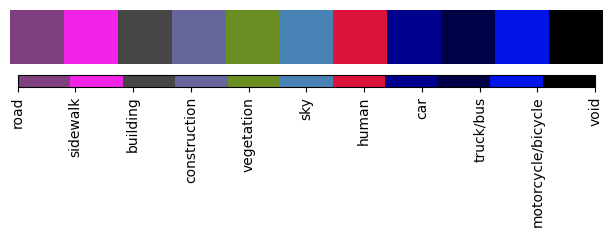

In [6]:
classes = [
            'road', 
           'sidewalk', 
           'building',
           'construction', 
         #   'object', 
           'vegetation', 
        #    'terrain', 
           'sky',
           'human', 
           'car', 
           'truck/bus', 
           'motorcycle/bicycle' ,  
           'void']

plot_class_colors(classes, cityscapes_cmap)

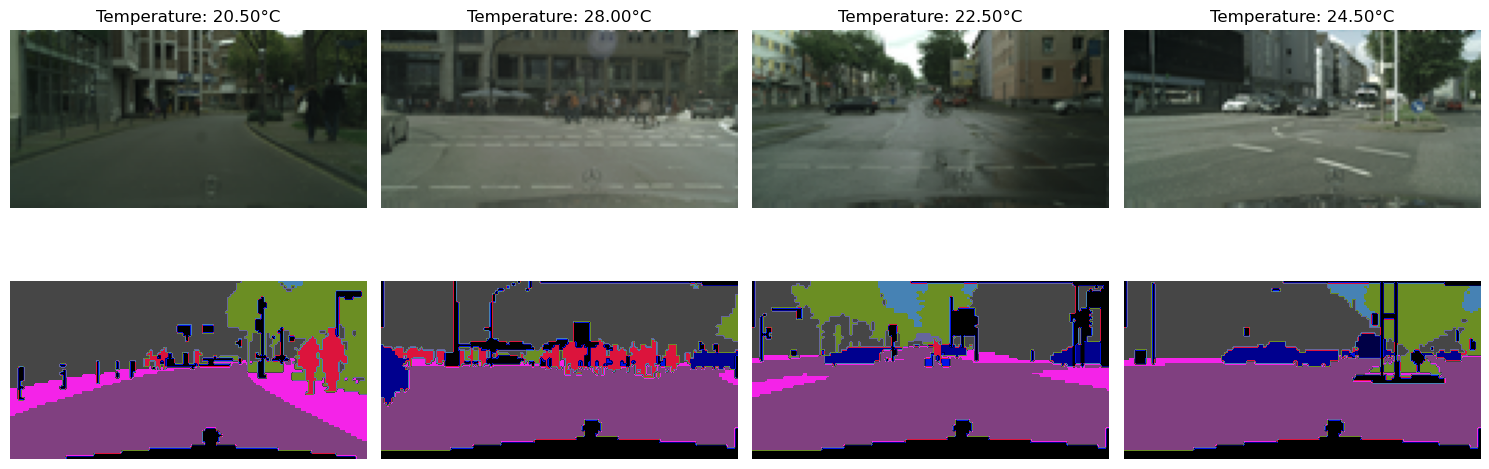

In [7]:
plot_samples(train_loader, unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))

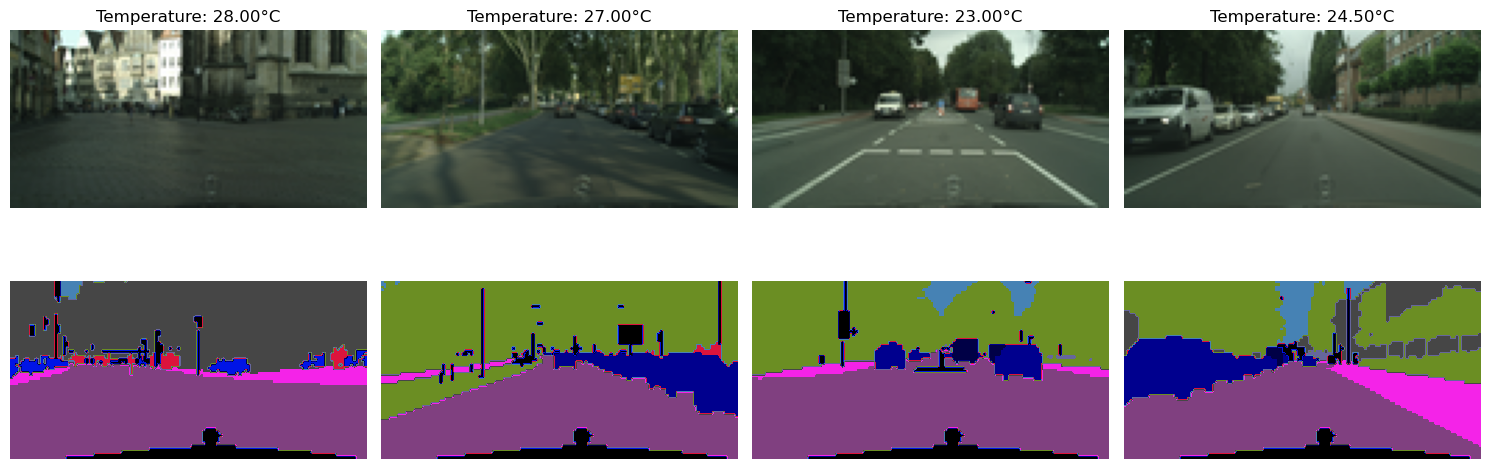

In [8]:
plot_samples(val_loader, unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))

In [9]:
from blocks import ResidualBlock, UpsampleBlock, ASPP, Bottleneck, UpsampleMaxPool

class ResidualUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResidualUNet, self).__init__()
        self.encoder1 = ResidualBlock(3, 64)
        self.encoder2 = ResidualBlock(64, 128, stride=2) # 1/2
        self.encoder3 = ResidualBlock(128, 256, stride=2) # 1/4
        self.encoder4 = ResidualBlock(256, 512, stride=2) # 1/8
        self.bridge = ResidualBlock(512, 1024, stride=2) # 1/16

        self.aspp_mask = ASPP(1024, 1024, [6, 12, 18])
        self.aspp_temp = ASPP(1024, 1024, [6, 12, 18])

        self.upsample1 = UpsampleBlock(1024, 512)
        self.upsample2 = UpsampleBlock(512, 256)
        self.upsample3 = UpsampleBlock(256, 128)
        self.upsample4 = UpsampleBlock(128, 64)

        self.mask_output = nn.Conv2d(64, num_classes, kernel_size=1)
        self.temp_output = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1024, 2048),
            # nn.ReLU(True),
            # nn.Linear(2048, 1)
        )

        self.lstm = nn.LSTM(input_size=2048, hidden_size=2048, 
                            num_layers=4, batch_first=True)
        
        self.final_fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.bridge(enc4)

        aspp_mask = self.aspp_mask(enc5)
        aspp_temp = self.aspp_temp(enc5)

        up1 = self.upsample1(aspp_mask, enc4)
        up2 = self.upsample2(up1, enc3)
        up3 = self.upsample3(up2, enc2)
        up4 = self.upsample4(up3, enc1)

        mask = self.mask_output(up4)
        temp = self.temp_output(aspp_temp) 
        lstm_out, (hidden, cell) = self.lstm(temp.unsqueeze(1))
        temp_out = self.final_fc(lstm_out[:, -1, :])

        return mask, temp_out

In [10]:
num_classes = 11
model = ResidualUNet(num_classes)
model = model.to(device)

total_epoch = 100

log_interval = 20


optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch)


In [11]:
best_val_acc = 0.0

train_loss = []
val_loss = []

train_mask_loss= []
val_mask_loss= []

train_mask_loss= []
val_mask_loss= []

train_temp_loss= []
val_temp_loss= []

train_epoch_iou =[]
val_epoch_iou =[]

for epoch in range(total_epoch):
    train(epoch, model, train_loader, optimizer, log_interval, num_classes, train_loss, train_epoch_iou, train_mask_loss , train_temp_loss)
    val_acc = evaluate(model, val_loader, device, num_classes, val_loss,val_epoch_iou, val_mask_loss,  val_temp_loss )
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_file = 'best_model.pth'
        torch.save(model.state_dict(), model_file)
        print('\nSaved best model to ' + model_file + '.')

    print()
    

Train Epoch: 0 [0/2975 (0%)]	Loss: 2.571	Mask Loss: 2.472, Temp Loss: 0.100
Train Epoch: 0 [240/2975 (8%)]	Loss: 2.114	Mask Loss: 1.256, Temp Loss: 0.858
Train Epoch: 0 [480/2975 (16%)]	Loss: 1.031	Mask Loss: 0.921, Temp Loss: 0.109
Train Epoch: 0 [720/2975 (24%)]	Loss: 0.975	Mask Loss: 0.876, Temp Loss: 0.098
Train Epoch: 0 [960/2975 (32%)]	Loss: 1.001	Mask Loss: 0.958, Temp Loss: 0.043
Train Epoch: 0 [1200/2975 (40%)]	Loss: 0.832	Mask Loss: 0.811, Temp Loss: 0.021
Train Epoch: 0 [1440/2975 (48%)]	Loss: 0.675	Mask Loss: 0.629, Temp Loss: 0.046
Train Epoch: 0 [1680/2975 (56%)]	Loss: 0.957	Mask Loss: 0.925, Temp Loss: 0.032
Train Epoch: 0 [1920/2975 (65%)]	Loss: 0.820	Mask Loss: 0.789, Temp Loss: 0.032
Train Epoch: 0 [2160/2975 (73%)]	Loss: 0.713	Mask Loss: 0.685, Temp Loss: 0.029
Train Epoch: 0 [2400/2975 (81%)]	Loss: 0.850	Mask Loss: 0.803, Temp Loss: 0.047
Train Epoch: 0 [2640/2975 (89%)]	Loss: 0.825	Mask Loss: 0.796, Temp Loss: 0.030
Train Epoch: 0 [2880/2975 (97%)]	Loss: 0.701	Mask

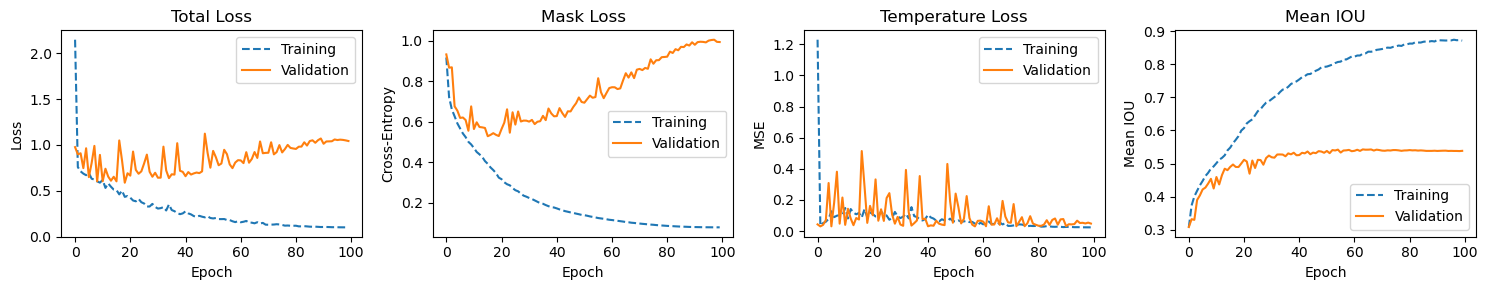

In [12]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 4, 1)
plt.plot(train_loss, label='Training', linestyle = 'dashed' )
plt.plot(val_loss, label='Validation', )
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(train_mask_loss, label='Training',  linestyle = 'dashed')
plt.plot(val_mask_loss, label='Validation')
plt.title('Mask Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()


plt.subplot(1, 4, 3)
plt.plot(train_temp_loss, label='Training',  linestyle = 'dashed')
plt.plot(val_temp_loss, label='Validation')
plt.title('Temperature Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()


plt.subplot(1, 4, 4)
plt.plot(train_epoch_iou, label='Training', linestyle = 'dashed')
plt.plot(val_epoch_iou, label='Validation')
plt.title('Mean IOU')
plt.xlabel('Epoch')
plt.ylabel('Mean IOU')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate Training data 

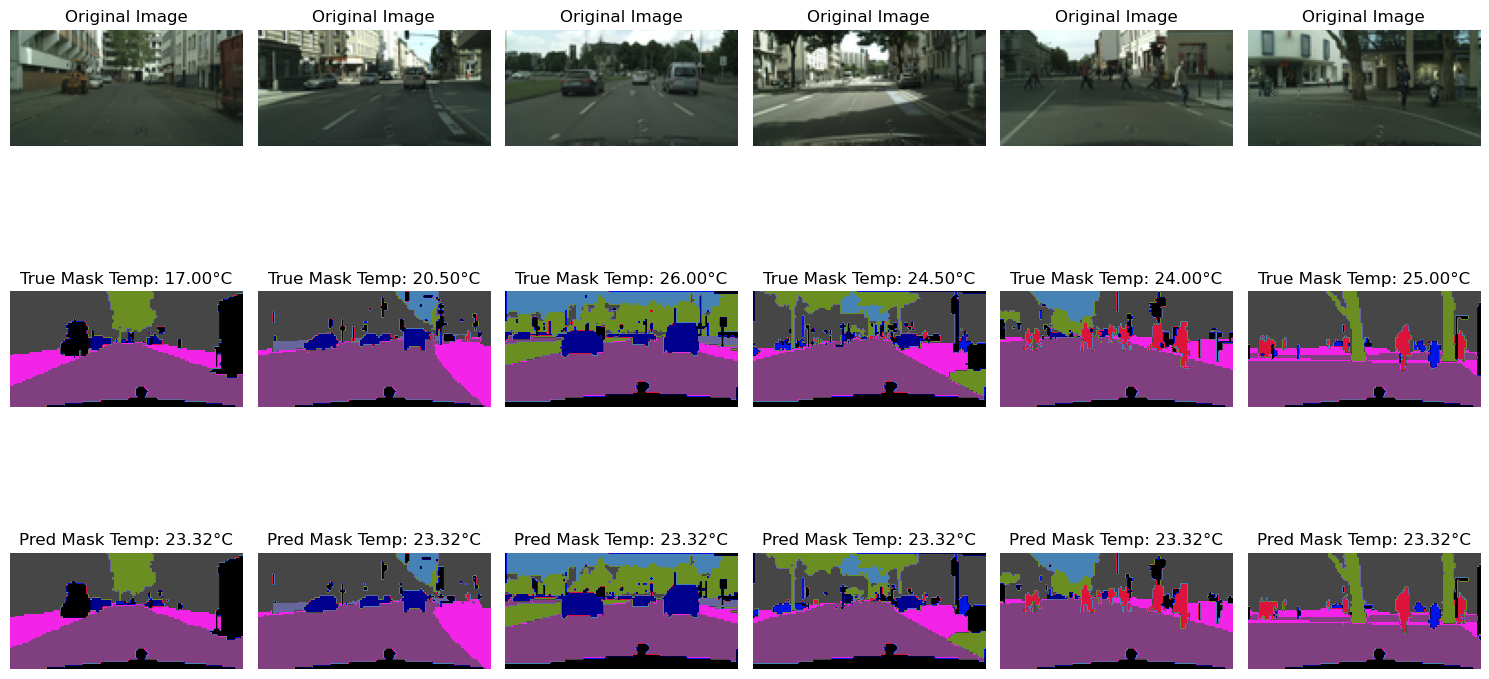

In [13]:
plot_predictions(model, train_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))

## Evaluate Validation data

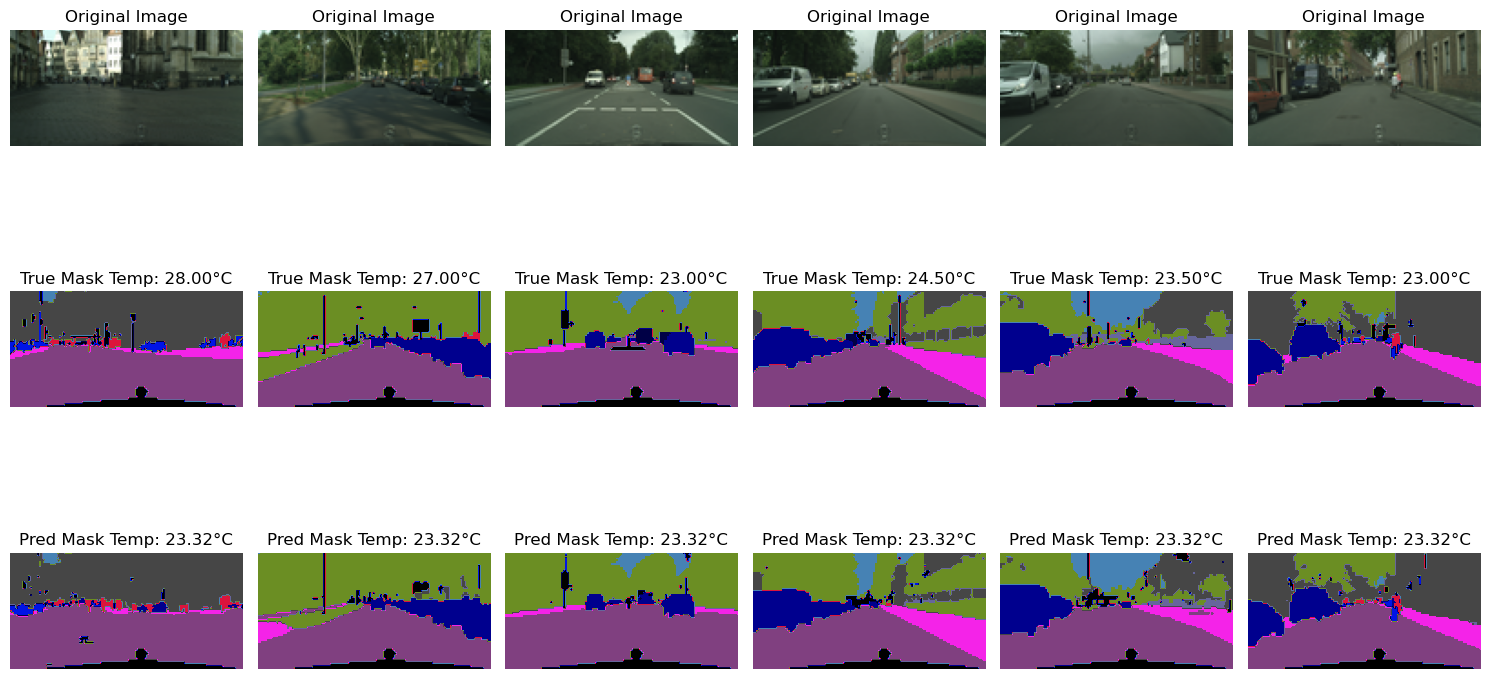

In [14]:
plot_predictions(model, val_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))

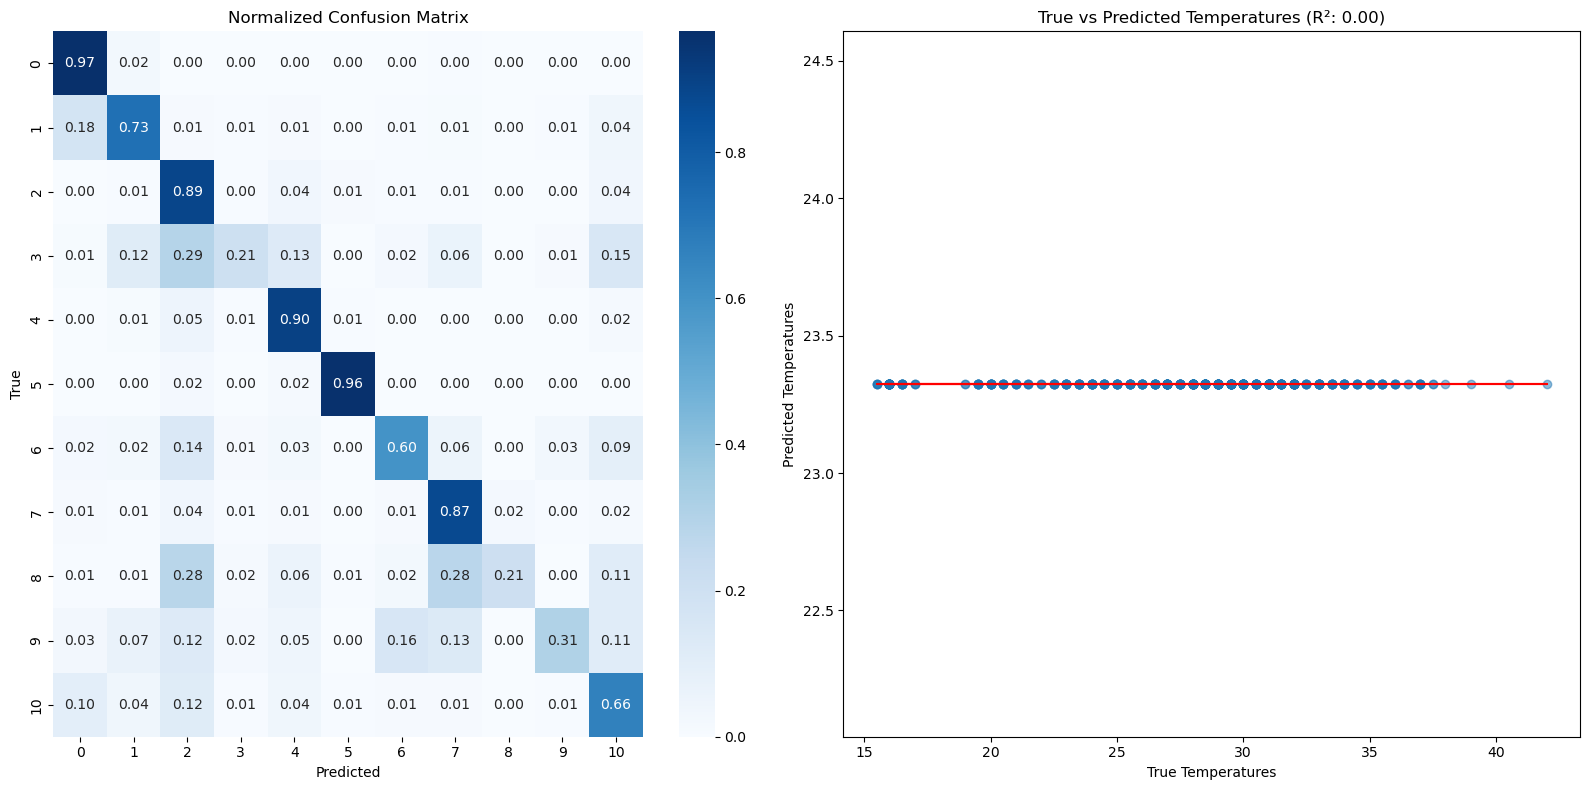

In [15]:
plot_metrics(model, val_loader, device, num_classes, temp_scale=(temp_min, temp_max))

In [16]:
from torch.utils.data import Subset
import random

test_dataset =   CityscapeSegTemp(root_dir = './data', split= 'test', 
                                 device = device, 
                                 transform = aug,
                                 temp_scale=(temp_min, temp_max)
                                 )



num_samples = 100
random_indices = random.sample(range(len(test_dataset)), num_samples)
test_dataset = Subset(test_dataset, random_indices)


test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

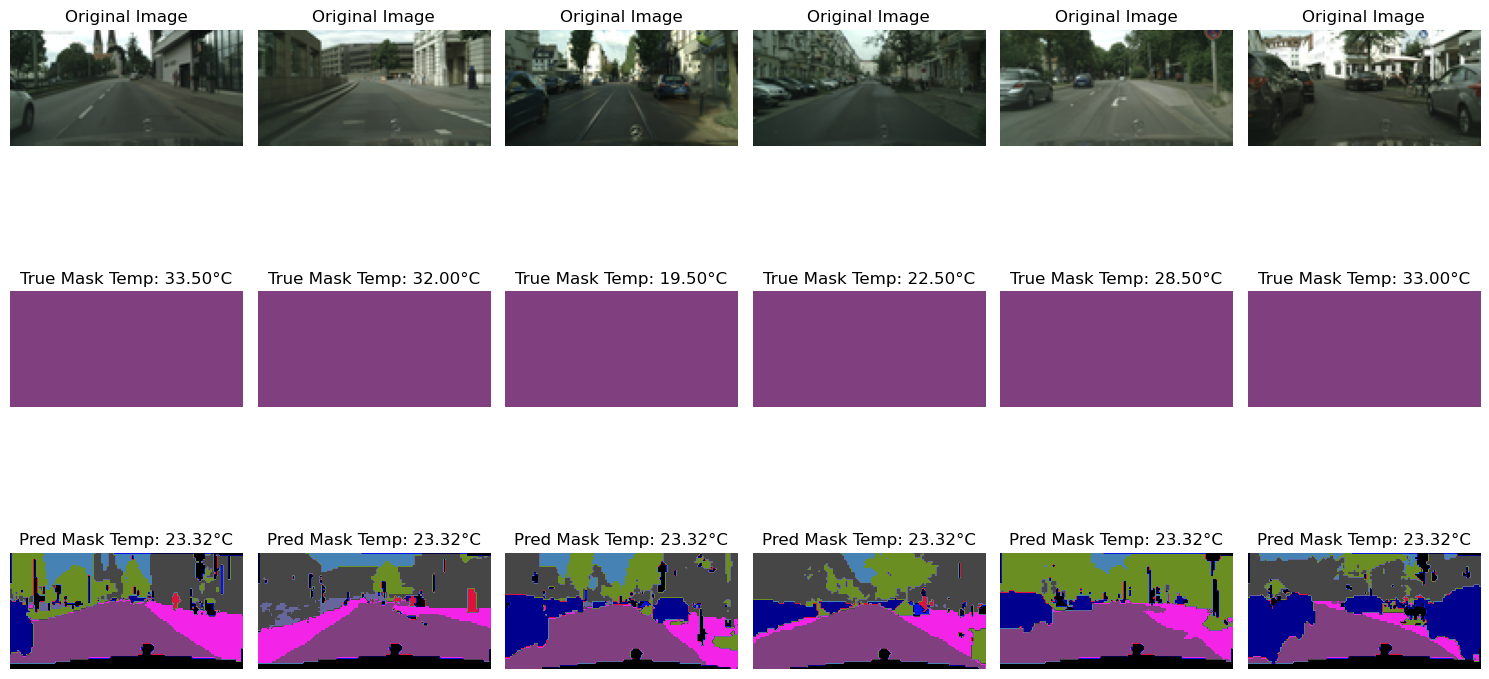

In [17]:
plot_predictions(model, test_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))